In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import io

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

## Check if GPU accelerator is allocated.

In [3]:
!nvidia-smi

Fri Dec 31 14:24:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Upload dataset to Google Colab

In [4]:
uploaded = files.upload()

Saving Data.csv to Data.csv


## Loading dataset

In [5]:
df = pd.read_csv(io.BytesIO(uploaded['Data.csv']))
df.head()

,Unnamed: 0,seq,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,chi,sharp,Jvar,Kvar,Lvar,Kamp,Var_Status
0,1,16707,17.963,0.0701,17.133,0.0198,16.686,0.0254,1.333,0.518,3.473,0.942,4.100,0.363,1
1,2,18468,99.999,9.9999,99.999,9.9999,17.990,0.2634,1.535,1.131,3.934,0.920,4.535,1.462,1
2,3,19086,18.975,0.1687,17.968,0.2616,17.945,0.0691,0.788,-0.288,4.828,0.955,5.782,0.584,1
3,4,1189,20.928,0.1792,19.093,0.4665,17.567,0.0725,0.809,-0.965,5.817,0.973,7.094,0.619,1
4,5,18133,18.930,0.2629,18.227,0.0489,17.237,0.0903,1.425,0.847,4.114,0.940,4.845,0.761,1


In [6]:
data = df[['Jmag','e_Jmag','Hmag','e_Hmag','Kmag','e_Kmag','chi','sharp','Jvar','Kvar','Lvar','Kamp','Var_Status']]

In [7]:
X = data[['Jmag','e_Jmag','Hmag','e_Hmag','Kmag','e_Kmag','chi','sharp','Jvar','Kvar','Lvar','Kamp']]
Y = data[['Var_Status']]

In [8]:
X_learning, X_test, Y_learning, Y_test = train_test_split(X, Y,test_size=0.2, random_state=42, stratify=Y)

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_learning, Y_learning,test_size=0.2, random_state=42, stratify=Y_learning)

## Data preprocessing

In [10]:
def df_to_dataset(X, y, shuffle=True, batch_size=32):
  df = X.copy()
  labels = y
  df = {key: value[:,tf.newaxis] for key, value in X.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [11]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [12]:
batch_size = 256
train_ds = df_to_dataset(X_train, Y_train, batch_size=batch_size)
val_ds = df_to_dataset(X_valid, Y_valid, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(X_test, Y_test, shuffle=False, batch_size=batch_size)

In [13]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['Jmag','e_Jmag','Hmag','e_Hmag','Kmag','e_Kmag','chi','sharp','Jvar','Kvar','Lvar','Kamp']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

## Model definition

In [14]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [15]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

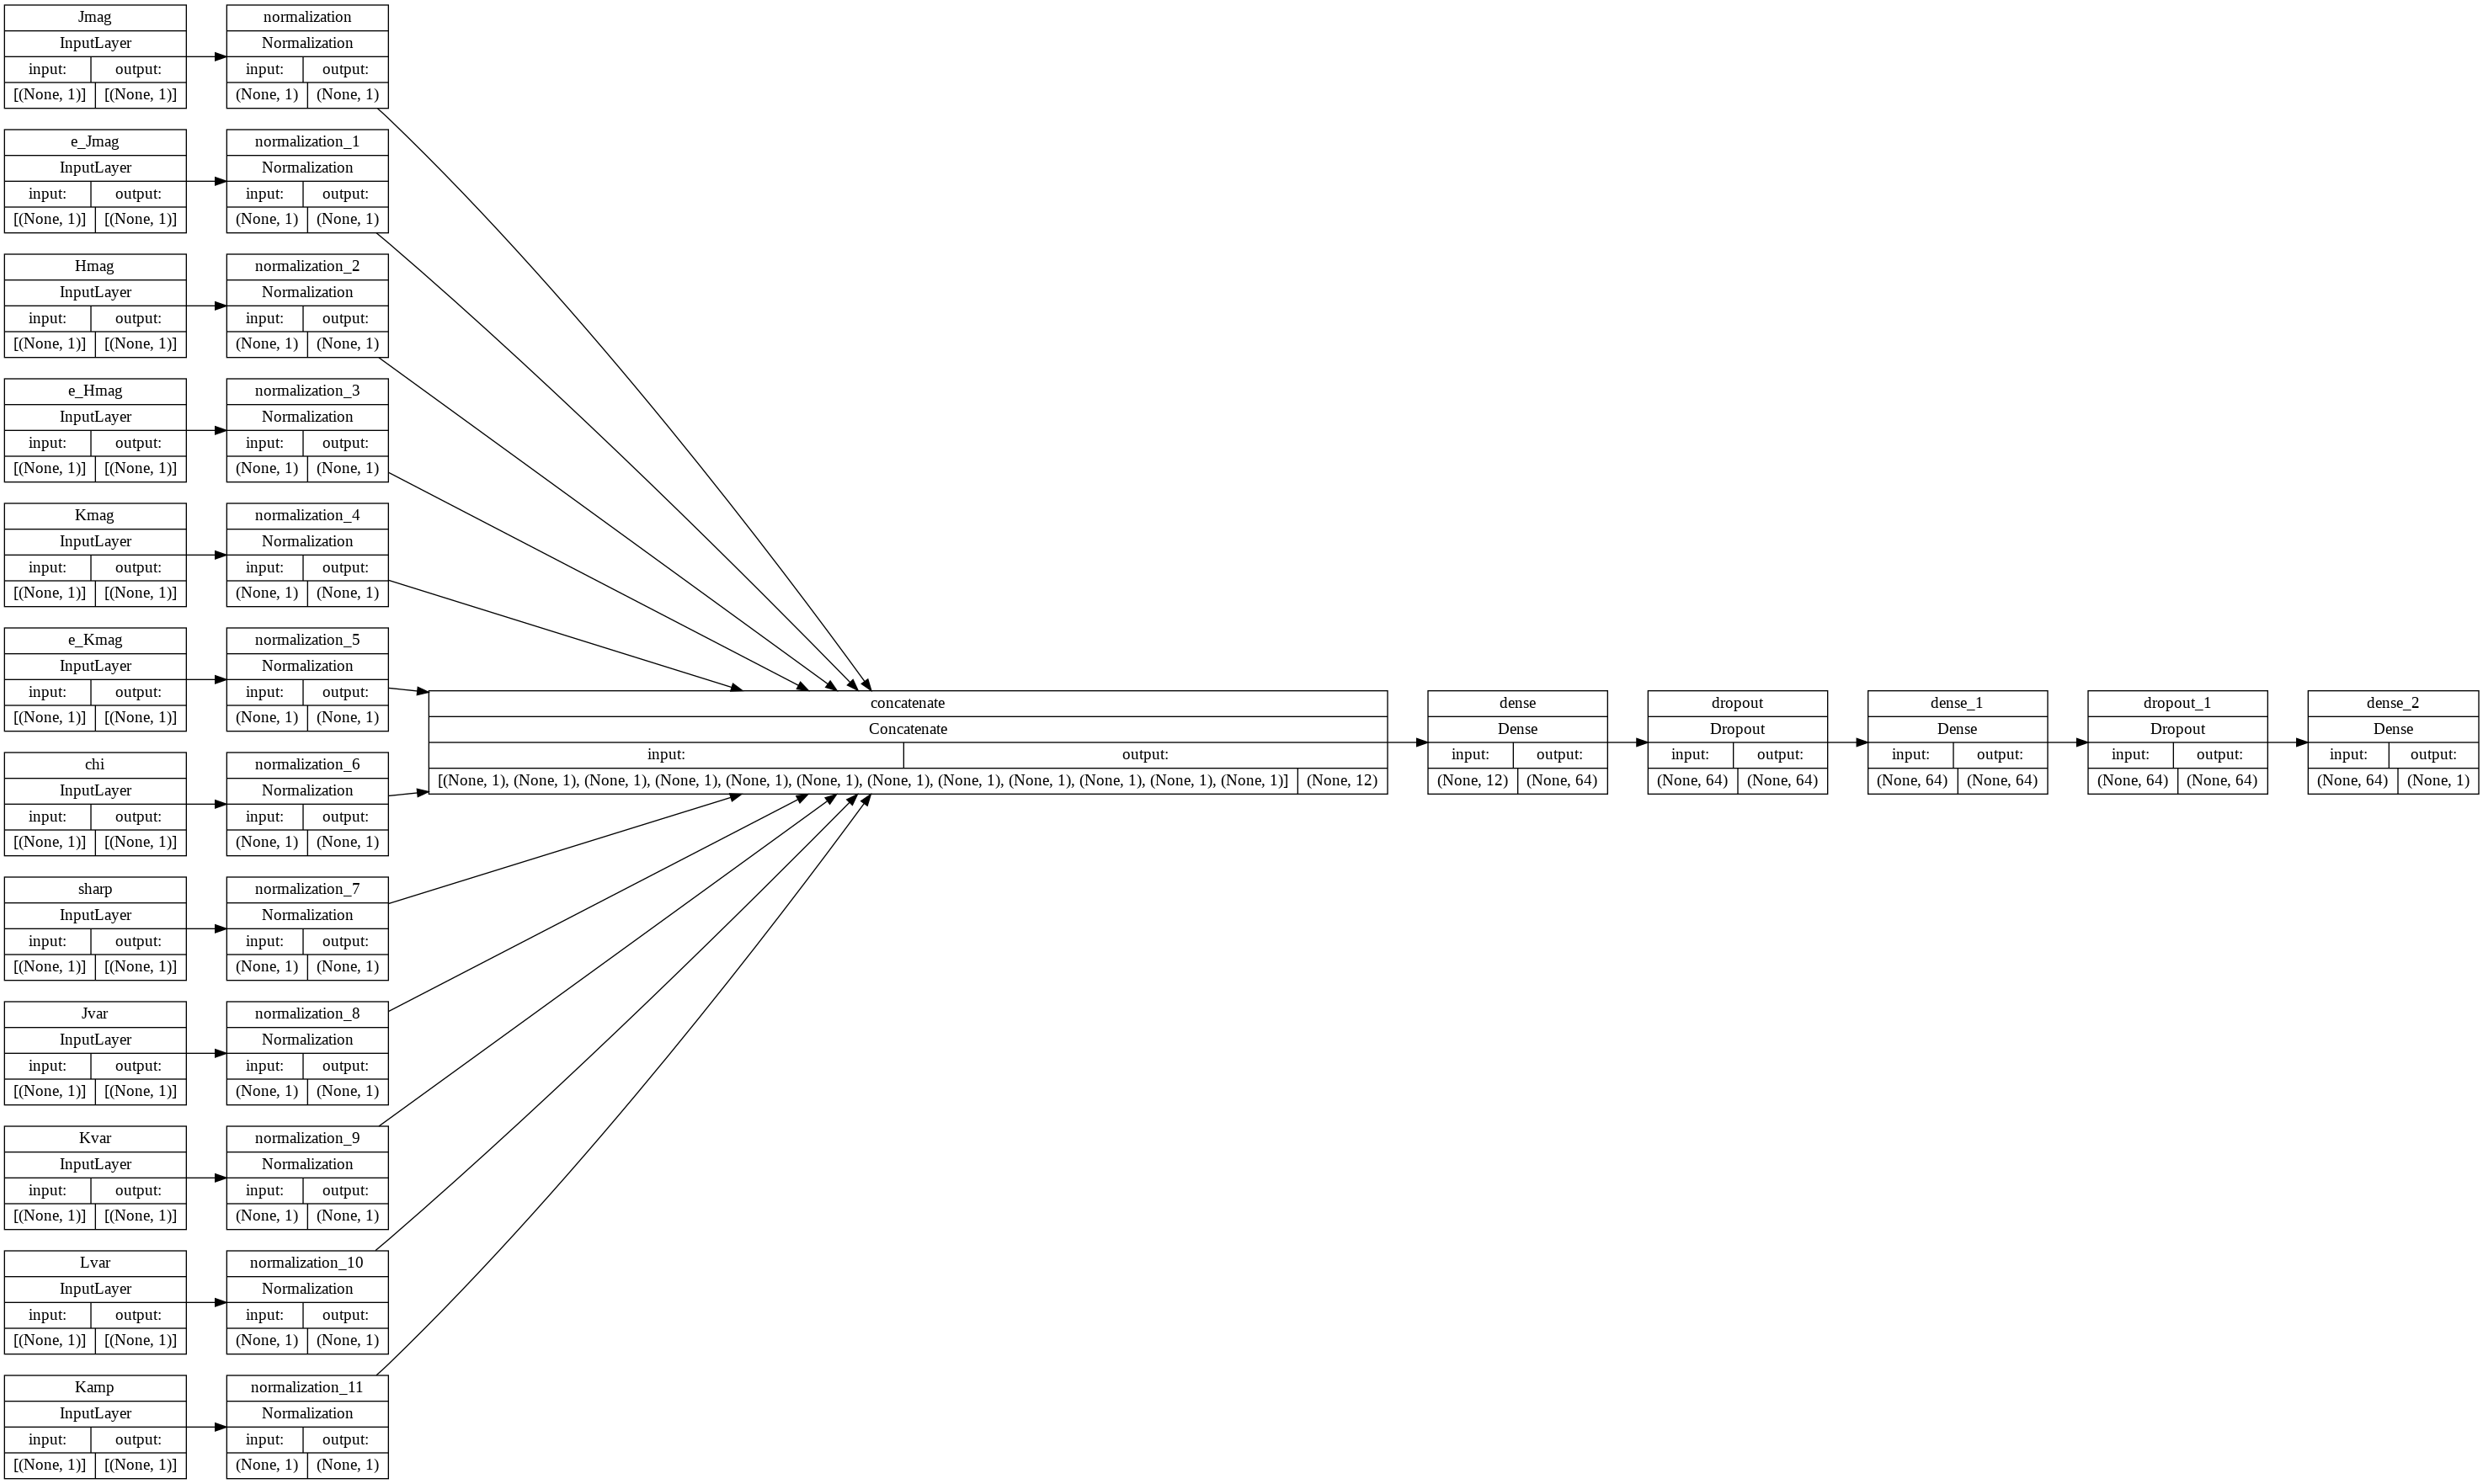

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training the model

In [17]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(filepath='model', 
                                       monitor='val_loss',
                                       mode='min',
                                       save_best_only=True),
]

In [18]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=my_callbacks)

Epoch 1/50
11/12 [==========================>...] - ETA: 0s - loss: 0.3239 - accuracy: 0.9045 

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 6s 328ms/step - loss: 0.3070 - accuracy: 0.9082 - val_loss: 0.0424 - val_accuracy: 0.9974
Epoch 2/50
 7/12 [================>.............] - ETA: 0s - loss: 0.0543 - accuracy: 0.9877

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 250ms/step - loss: 0.0429 - accuracy: 0.9905 - val_loss: 0.0062 - val_accuracy: 0.9987
Epoch 3/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0143 - accuracy: 0.9965

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 264ms/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0043 - accuracy: 0.9992

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 246ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 5.1307e-04 - val_accuracy: 1.0000
Epoch 5/50
 9/12 [=====================>........] - ETA: 0s - loss: 0.0034 - accuracy: 0.9978

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 241ms/step - loss: 0.0031 - accuracy: 0.9984 - val_loss: 3.1850e-04 - val_accuracy: 1.0000
Epoch 6/50
10/12 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 0.9996    

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 264ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 2.6193e-04 - val_accuracy: 1.0000
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 3.0770e-04 - val_accuracy: 1.0000
Epoch 8/50
10/12 [========================>.....] - ETA: 0s - loss: 9.8992e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 244ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.4632e-04 - val_accuracy: 1.0000
Epoch 9/50
 9/12 [=====================>........] - ETA: 0s - loss: 0.0017 - accuracy: 0.9991

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 246ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 1.7221e-04 - val_accuracy: 1.0000
Epoch 10/50
 9/12 [=====================>........] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996    

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 266ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.6867e-04 - val_accuracy: 1.0000
Epoch 11/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 1.7935e-04 - val_accuracy: 1.0000
Epoch 12/50
 9/12 [=====================>........] - ETA: 0s - loss: 0.0011 - accuracy: 0.9996    

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 251ms/step - loss: 9.5200e-04 - accuracy: 0.9997 - val_loss: 1.1834e-04 - val_accuracy: 1.0000
Epoch 13/50
 9/12 [=====================>........] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 244ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 5.8223e-05 - val_accuracy: 1.0000
Epoch 14/50
 9/12 [=====================>........] - ETA: 0s - loss: 4.6968e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 269ms/step - loss: 4.3062e-04 - accuracy: 1.0000 - val_loss: 4.9235e-05 - val_accuracy: 1.0000
Epoch 15/50
 8/12 [===================>..........] - ETA: 0s - loss: 7.5917e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 251ms/step - loss: 7.8679e-04 - accuracy: 1.0000 - val_loss: 3.3802e-05 - val_accuracy: 1.0000
Epoch 16/50
 9/12 [=====================>........] - ETA: 0s - loss: 6.1556e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 249ms/step - loss: 5.5830e-04 - accuracy: 1.0000 - val_loss: 1.8023e-05 - val_accuracy: 1.0000
Epoch 17/50
 9/12 [=====================>........] - ETA: 0s - loss: 4.3783e-04 - accuracy: 0.9996

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 269ms/step - loss: 3.9274e-04 - accuracy: 0.9997 - val_loss: 1.5513e-05 - val_accuracy: 1.0000
Epoch 18/50
12/12 [==============================] - 0s 9ms/step - loss: 1.8596e-04 - accuracy: 1.0000 - val_loss: 1.5687e-05 - val_accuracy: 1.0000
Epoch 19/50
 9/12 [=====================>........] - ETA: 0s - loss: 7.3234e-04 - accuracy: 0.9996

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


12/12 [==============================] - 3s 248ms/step - loss: 6.2612e-04 - accuracy: 0.9997 - val_loss: 1.1829e-05 - val_accuracy: 1.0000
Epoch 20/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 4.0179e-04 - val_accuracy: 1.0000
Epoch 21/50
12/12 [==============================] - 0s 9ms/step - loss: 3.9627e-04 - accuracy: 1.0000 - val_loss: 3.9296e-04 - val_accuracy: 1.0000


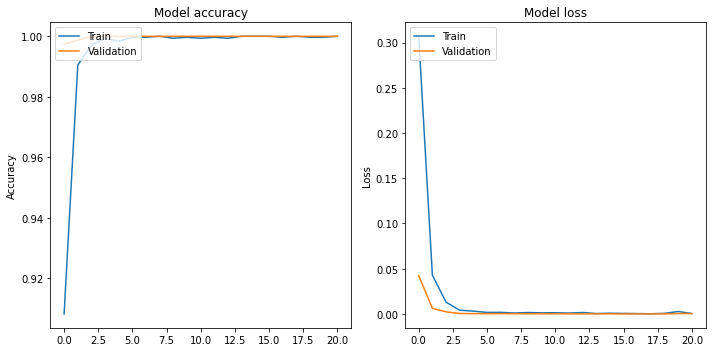

In [19]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Evaluating the model

In [20]:
loss, accuracy = model.evaluate(test_ds)
print("Test set accuracy", accuracy)

4/4 [==============================] - 0s 6ms/step - loss: 7.6013e-05 - accuracy: 1.0000
Test set accuracy 1.0


## Saving and downloading the model

In [21]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 94%)
  adding: model/saved_model.pb (deflated 89%)
  adding: model/assets/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 72%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 17%)


In [22]:
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>